# Import Library

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import os

# Choice a Image

In [2]:
print("Please enter 1(Original image) or 2(My select image) : ")
choice = int(input())

if choice == 1:
    path = "./img/original.jpg"
elif choice == 2:
    path = "./img/mySelect.jpg"
else:
    print("error!")

Please enter 1(Original image) or 2(My select image) : 
1


# Read the Image
- cv2.imread

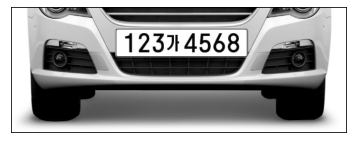

In [3]:
imgCar = cv2.imread(path)

height, width, channel = imgCar.shape

plt.imshow(imgCar[:, :, ::-1])
plt.xticks([])
plt.yticks([])
plt.show()

# Convert to Gray Scale
- cv2.cvtColor

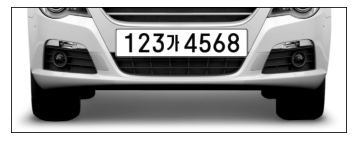

In [4]:
grayCar = cv2.cvtColor(imgCar, cv2.COLOR_BGR2GRAY)

plt.imshow(grayCar, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

# Apply to Gaussian Blur
- cv2.GaussianBlur

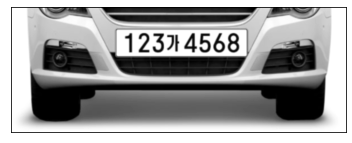

In [5]:
carBlur = cv2.GaussianBlur(grayCar, ksize = (3, 3), sigmaX = 0)

plt.imshow(carBlur, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

# Apply to Adaptive Threshold
- cv2.adaptiveThreshold

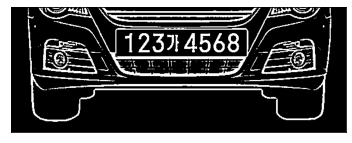

In [6]:
carThresh = cv2.adaptiveThreshold(
    carBlur,
    maxValue = 255,
    adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # 가우시안 분포에 따른 가중치의 합으로 경계 값 결정
    thresholdType = cv2.THRESH_BINARY_INV, # 픽셀 값이 경계 값을 넘으면 0, 넘지 못하면 value
    blockSize = 9,
    C = 5 # 계산 된 경계 값 결과에서 가감할 상수
)

plt.imshow(carThresh, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

# Find Contours
- cv2.findContours
- cv2.drawContours

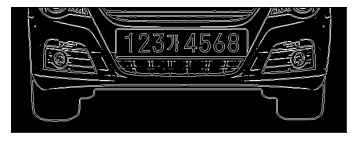

In [7]:
contours, _ = cv2.findContours(
    carThresh,
    mode = cv2.RETR_LIST, # 모든 라인을 계층 없이 제공
    method = cv2.CHAIN_APPROX_SIMPLE # 컨투어 꼭짓점 좌표만 제공
)

carLine = np.zeros((height, width, channel), dtype = np.uint8)
cv2.drawContours(
    carLine,
    contours = contours,
    contourIdx = -1, # -1 : 모든 컨투어
    color = (255, 255, 255))

plt.imshow(carLine)
plt.xticks([])
plt.yticks([])
plt.show()

# Change the Contours to Squares
- cv2.boundingRect
- cv2.rectangle

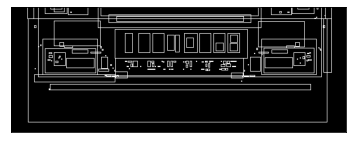

In [8]:
carRectangle = np.zeros((height, width, channel), dtype = np.uint8)

contoursDict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    cv2.rectangle(
        carRectangle,
        pt1 = (x, y),
        pt2 = (x + w, y + h),
        color = (255, 255, 255)
    )
    
    contoursDict.append({
        'contour' : contour,
        'x' : x,
        'y' : y,
        'w' : w,
        'h' : h,
        'xCenter' : x + (w / 2),
        'yCenter' : y + (h / 2)
    })

plt.imshow(carRectangle)
plt.xticks([])
plt.yticks([])
plt.show()

# Find Rectangle the Size of a Character
- cv2.rectangle

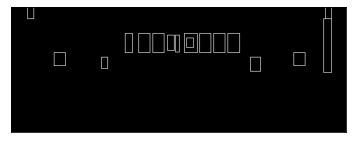

In [9]:
minArea = 50
minWidth = 5
minHeight = 10
minRatio = 0.1
maxRatio = 0.9
count = 0
possibleContours = []

for dic in contoursDict:
    area = dic['w'] * dic['h']
    ratio = dic['w'] / dic['h']
    
    if area > minArea and dic['w'] > minWidth and dic['h'] > minHeight and minRatio < ratio < maxRatio:
        dic['index'] = count
        count += 1
        possibleContours.append(dic)

carPossibleRectangle = np.zeros((height, width, channel), dtype = np.uint8)

for contour in possibleContours:
    cv2.rectangle(
        carPossibleRectangle,
        pt1 = (contour['x'], contour['y']),
        pt2 = (contour['x'] + contour['w'], contour['y'] + contour['h']),
        color = (255, 255, 255),
    )

plt.imshow(carPossibleRectangle, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

# Function to Find Possible License Plate Contours

In [10]:
maxDiagMultiplyer = 4
maxAngleDiff = 20
maxAreaDiff = 0.6
maxWidthDiff = 0.4
maxHeightDiff = 0.2
minMatched = 5

def findChars(contourList):
    matchedIndex = []
    
    for contour1 in contourList:
        matchedContoursIndex = []
        
        # 컨투어가 주변에 있다면 matchedContoursIndex에 인덱스 추가
        for contour2 in contourList:
            if contour1['index'] == contour2['index']:
                continue
            
            diffX = abs(contour1['xCenter'] - contour2['xCenter'])
            diffY = abs(contour1['yCenter'] - contour2['yCenter'])
            diagonal = np.sqrt(contour1['w'] ** 2 + contour1['h'] ** 2)
            # 처음 컨투어 센터 좌표와 끝 컨터어 센터 좌표의 길이
            distance = np.linalg.norm(np.array([contour1['xCenter'], contour1['yCenter']]) - np. array([contour2['xCenter'], contour2['yCenter']]))
            
            if diffX == 0:
                angleDiff = 90
            else:
                angleDiff = np.degrees(np.arctan(diffY / diffX))
            
            areaDiff = abs(contour1['w'] * contour1['h'] - contour2['w'] * contour2['h']) / (contour1['w'] * contour1['h'])
            widthDiff = abs(contour1['w'] - contour2['w']) / contour1['w']
            heightDiff = abs(contour1['h'] - contour2['h']) / contour1['h']
            
            if distance < diagonal * maxDiagMultiplyer and angleDiff < maxAngleDiff and areaDiff < maxAreaDiff and widthDiff < maxWidthDiff and heightDiff < maxHeightDiff:
                matchedContoursIndex.append(contour2['index'])
        
        # 현재 컨투어 인덱스 matchedContoursIndex에 추가
        matchedContoursIndex.append(contour1['index'])
        
        # 주변 컨투어가 5개 미만일 때
        if len(matchedContoursIndex) < minMatched:
            continue
        
        matchedIndex.append(matchedContoursIndex)
        
    return matchedIndex

# Possible License Plate Contours
- cv2.rectangle

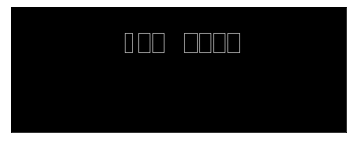

In [11]:
matchedIndex = findChars(possibleContours)

matched = []

for index in matchedIndex:
    matched.append(np.take(possibleContours, index))

carFindRectangle = np.zeros((height, width, channel), dtype = np.uint8)

for mat in matched:
    for m in mat:
        cv2.rectangle(
            carFindRectangle,
            pt1 = (m['x'], m['y']),
            pt2 = (m['x'] + m['w'], m['y'] + m['h']),
            color = (255, 255, 255),
        )

plt.imshow(carFindRectangle, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

# Make License Plates into Rectangles
- cv2.getRotationMatrix2D
- cv2.warpAffine
- cv2.getRectSubPix

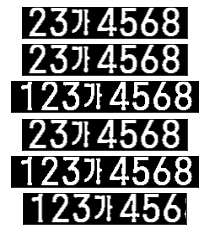

In [12]:
plateWidthPadding = 1.1
plateHeightPadding = 1.1
minPlateRatio = 2
maxPlateRatio = 10
padding = 5

plates = []
plateInfos = []

for i, matchedChars in enumerate(matched):
    sortedChars = sorted(matchedChars, key = lambda x: x['xCenter'])
    
    xPlateCenter = (sortedChars[0]['xCenter'] + sortedChars[-1]['xCenter']) / 2
    yPlateCenter = (sortedChars[0]['yCenter'] + sortedChars[-1]['yCenter']) / 2
    
    plateWidth = abs((sortedChars[-1]['x'] + sortedChars[-1]['w'] - sortedChars[0]['x'])) * plateWidthPadding
    
    sumHeight = 0
    
    for dic in sortedChars:
        sumHeight += dic['h']
    
    plateHeight = int(sumHeight / len(sortedChars) * plateHeightPadding)
    
    triangleHeight = sortedChars[-1]['yCenter'] - sortedChars[0]['yCenter']
    # np.linalg.norm : 처음 센터 좌표와 끝 센터 좌표의 거리
    triangleHypotenus = np.linalg.norm(
        np.array([sortedChars[0]['xCenter'], sortedChars[0]['yCenter']]) - np.array([sortedChars[-1]['xCenter'], sortedChars[-1]['yCenter']])
    )
    # np.degrees : 삼각함수 값을 각도로
    # np.arcsin : 삼각함수
    angle = np.degrees(np.arcsin(triangleHeight / triangleHypotenus))
    
    rotationMatrix = cv2.getRotationMatrix2D(
        center = (xPlateCenter, yPlateCenter),
        angle = angle,
        scale = 1.0
    )
    rotated = cv2.warpAffine(carThresh,
                             M = rotationMatrix, # 변환행렬
                             dsize = (width, height)
                            )
    cropped = cv2.getRectSubPix(
        rotated,
        patchSize = (int(plateWidth), int(plateHeight)),
        center = (int(xPlateCenter), int(yPlateCenter))
    )
    
    if cropped.shape[1] / cropped.shape[0] < minPlateRatio or cropped.shape[1] / cropped.shape[0] > maxPlateRatio:
        continue
    
    plates.append(cropped)
    plateInfos.append(np.array([
        [sortedChars[0]['x'] - padding, sortedChars[0]['y'] - padding],
        [sortedChars[0]['x'] - padding, sortedChars[0]['y'] + sortedChars[0]['h'] + padding],
        [sortedChars[-1]['x'] + sortedChars[-1]['w'] + padding, sortedChars[-1]['y'] + sortedChars[-1]['h'] + padding],
        [sortedChars[-1]['x'] + sortedChars[-1]['w'] + padding, sortedChars[-1]['y'] - padding],
    ], np.int32))
    
    plt.subplot(len(matched), 1, i + 1)
    plt.imshow(cropped, cmap = 'gray')
    plt.xticks([])
    plt.yticks([])

plt.show()

# Change images to string
- cv2.resize
- cv2.threshold
- cv2.findContours
- cv2.boundingRect
- cv2.GaussianBlur
- cv2.copyMakeBorder

### need to install pytesseract!!
I referenced the blog -> [link](https://ddolcat.tistory.com/954 "click")

23가4568
23가4568
123가4568
23가4568
123가4568
123가456


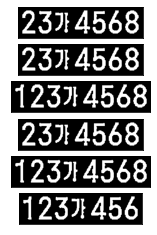

In [13]:
plateIndex = -1
plateLen = 8
plateChars = []

for i, plate in enumerate(plates):
    plate = cv2.resize(
        plate,
        dsize = (0, 0),
        fx = 1.5, # 배율 (dsize가 0일 때)
        fy = 1.5 # 배율 (dsize가 0일 때)
    )
    # resize에 선형보간법이 사용되므로 threshold 다시 사용
    _, plate = cv2.threshold(plate, thresh = 0.0, maxval = 255.0,
                             type = cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # 컨투어 다시 찾기
    contours, _ = cv2.findContours(
        plate,
        mode = cv2.RETR_LIST, # 모든 라인을 계층 없이 제공
        method = cv2.CHAIN_APPROX_SIMPLE # 컨투어 꼭짓점 좌표만 제공
    )
    
    minPlateX, minPlateY = plate.shape[1], plate.shape[0]
    maxPlateX, maxPlateY = 0, 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h
        
        if area > minArea and w > minWidth and h > minHeight and minRatio < ratio < maxRatio:
            if x < minPlateX:
                minPlateX = x
            if y < minPlateY:
                minPlateY = y
            if x + w > maxPlateX:
                maxPlateX = x + w
            if y + h > maxPlateY:
                maxPlateY = y + h
    
    plateThresh = plate[minPlateY:maxPlateY, minPlateX:maxPlateX]
    
    # 글자를 잘 인식하기 위해 노이즈제거와 쓰레시홀딩
    plateThresh = cv2.GaussianBlur(plateThresh, ksize = (3, 3), sigmaX = 0)
    _, plateThresh = cv2.threshold(plateThresh, thresh = 0.0, maxval = 255.0,
                              type = cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # 이미지 테두리 만들기
    plateThresh = cv2.copyMakeBorder(plateThresh, top = 10, bottom = 10, left = 10, right = 10,
                                borderType = cv2.BORDER_CONSTANT, value = (0, 0, 0))
    
    pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract.exe"
    # --psm 7 : Treat the image as a single text line.
    chars = pytesseract.image_to_string(plateThresh, lang = 'kor', config = '--psm 7 --oem 0')
    
    string = ''

    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            string += c

    print(string)
    plateChars.append(string)

    if string[3].isdigit() == False and len(string) == plateLen:
        plateIndex = i

    plt.subplot(len(plates), 1, i + 1)
    plt.imshow(plateThresh, cmap = 'gray')
    plt.xticks([])
    plt.yticks([])

plt.show()

# Final
- cv2.polylines
- cv2.imencode

123가4568


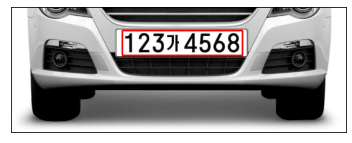

In [14]:
info = plateInfos[plateIndex]
chars = plateChars[plateIndex]

print(chars)

resultImg = imgCar.copy()

cv2.polylines(resultImg, [info], True, (0, 0, 255), 2)

# cv2.imwrite는 한글이 들어간 이름을 사용하지 못하므로 cv2.imencode 사용
extension = os.path.splitext(chars + '.jpg')[1]
result, encoded_img = cv2.imencode(extension, resultImg)
if result:
    with open(chars + '.jpg', mode='w+b') as f:
        encoded_img.tofile(f)

plt.imshow(resultImg[:, :, ::-1])
plt.xticks([])
plt.yticks([])
plt.show()